## Tokamesh - geometry matrix calculation demo
This notebook demonstrates how to calculate a geometry matrix using tools from the `tokamesh.geometry` module.

First, we need to set-up a test case. Start by building a simple mesh:

In [1]:
# create an equilateral mesh covering the specified area
from tokamesh.construction import equilateral_mesh
R, z, triangles = equilateral_mesh(
    R_range=(0.3, 1.5),
    z_range=(-0.5, 0.5),
    resolution=0.03
)

Now define an example emission function which specifies an emission at each vertex:

In [2]:
from numpy import sqrt, exp
def emission_func(R, z):
    w = 0.05
    r = sqrt((R-0.8)**2 + (z+0.1)**2)
    return exp(-0.5*(r/w)**4) + 0.5*exp(-0.5*((r - 0.3)/w)**2)

# evaluate the emission at each vertex of the mesh
emission = emission_func(R, z)

Use the `get_field_image` of the `TriangularMesh` class to create an image of the emission function interpolated on the mesh and plot it

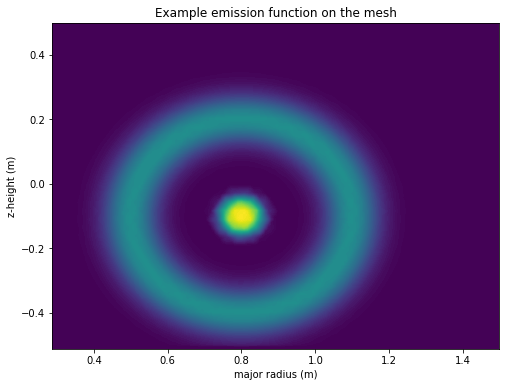

In [3]:
from tokamesh import TriangularMesh
mesh = TriangularMesh(R, z, triangles)
emission_R, emission_z, emission_image = mesh.get_field_image(vertex_values=emission)

# plot the emission
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.contourf(emission_R, emission_z, emission_image.T, 100)
ax.set_title('Example emission function on the mesh')
ax.set_xlabel('major radius (m)')
ax.set_ylabel('z-height (m)')
plt.show()

Now we use the `Camera` class to generate lines of sight which will image the emission distribution

In [4]:
from numpy import array
from tokamesh.geometry import Camera
pixels = 150
cam = Camera(
    position=array([1.6,1.8,1.25]),
    direction=array([-1.,-0.7,-0.8]),
    fov=40.,
    max_distance=4.,
    num_x=pixels,
    num_y=pixels
)

Now the test-case is set-up, we can calculate the geometry matrix using the `BarycentricGeometryMatrix` class

In [5]:
from tokamesh.geometry import BarycentricGeometryMatrix
BGM = BarycentricGeometryMatrix(
    R=R,
    z=z,
    triangles=triangles,
    ray_origins=cam.ray_starts,
    ray_ends=cam.ray_ends
)

matrix_data = BGM.calculate()

 >> Calculating geometry matrix:  [ completed in 0:00:18 sec ]               


The calculated geometry matrix is returned as a dictionary of numpy arrays which can be used as inputs to sparse matrix classes from the `scipy.sparse` library. Here, we use the output to construct a `csc_matrix`:

In [6]:
from scipy.sparse import csc_matrix
entry_values = matrix_data['entry_values']
row_inds = matrix_data['row_indices']
col_inds = matrix_data['col_indices']
shape = matrix_data['shape']
G = csc_matrix((entry_values, (row_inds, col_inds)), shape=shape)

Taking the matrix-vector product of the geometry matrix and the emission values at each vertex yields a vector of the brightness of each camera pixel:

In [7]:
pixel_brightness = G.dot(emission)
# re-shape the pixel brightness into an image
brightness_image = pixel_brightness.reshape([pixels,pixels])

Now plot the geometry matrix prediction of the camera image of the emission distribution

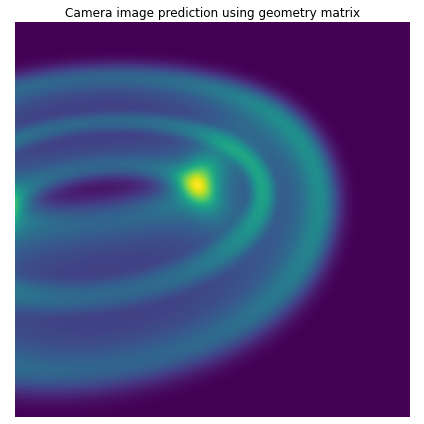

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(brightness_image.T)
ax.axis('equal')
ax.set_title('Camera image prediction using geometry matrix')
ax.axis('off')
plt.tight_layout()
plt.show()